# RECOMMENDATION SYSTEMS PROJECT 
##### BY DUVVURU LOKESH

#### DATASET : ELECTRONICS DATASET FROM Amazon reviews data

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
import os
from collections import defaultdict
from surprise import SVD
from sklearn.decomposition import TruncatedSVD

## 1-- READ AND EXPLORE THE DATASET

In [2]:
#reading the data and re-naming the columns
data = pd.read_csv("ratings_Electronics.csv" ,names=['userId', 'productId','Rating','timestamp'])

In [3]:
#head of the data
data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
# shape of the data
data.shape

(7824482, 4)

##### There are 7824482 rows and 4 columns

In [5]:
# 5 point summary
data.describe()

,Rating,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [6]:
# No of unique users
len(np.unique(data.userId))

4201696

##### There are 4201696 users who rated 

In [7]:
# No of unique products
len(np.unique(data.productId))

476002

##### There are 476002 products

In [8]:
# dropping the time stamp column
df=data.drop(['timestamp'], axis = 1)

##### timestamp column dropped as it is not useful in this case

In [9]:
# head of the new dataset
df.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [10]:
#Info of new dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
Rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [11]:
df.isna().apply(pd.value_counts) #checking the presence of missing values

,userId,productId,Rating
False,7824482,7824482,7824482


##### No missing values

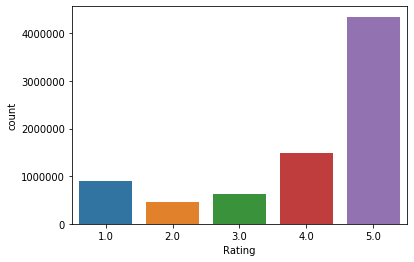

In [12]:
# countplot
sns.countplot(data=df , x='Rating')
plt.show()

##### Here maximum number products gave rating of 5

## 2-- TAKE SUBSET OF DATA

In [13]:
# NO of ratings given by each user
no_of_rated_products_per_user = df.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [14]:
# NO of users who rated 75 or more products
sum(no_of_rated_products_per_user >= 75)

582

##### 582 users rated atleast 75 products

In [15]:
# creating subset of of original data
e_df=df.groupby("productId").filter(lambda x:x['Rating'].count() >=75)

##### Here i am creating subset with users who atleast rated 75 products

In [16]:
#Head of subset data
e_df.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [17]:
e_df.shape

(4860410, 3)

## 4-- POPULARITY RECOMMENDER MODEL

In [18]:
e_df.groupby('productId')['Rating'].mean().head()  

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

##### Mean rating for each product is determined by grouping productID and rating

In [19]:
e_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()  

productId
B0043ZLFXE    4.955556
B00GMRCAC6    4.951872
B008I6RVZU    4.951456
B00CG70K78    4.949367
B0000DYV9H    4.947368
Name: Rating, dtype: float64

##### Mean rating of products in descending order.
##### This gives the most highly rated product at top

In [20]:
e_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()  

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

##### Most ratings for a single product is at the top of this count values

In [21]:
ratings_mean_count = pd.DataFrame(e_df.groupby('productId')['Rating'].mean())

##### New dataframe ratings_mean_count is created and mean values are included

In [22]:
ratings_mean_count['Rating_counts'] = pd.DataFrame(e_df.groupby('productId')['Rating'].count())  

##### Rating_counts values are included to the ratings_mean_count dataframe

In [23]:
ratings_mean_count.head() 

,Rating,Rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


##### Head of the ratings_mean_count dataframe is shown above 

In [24]:
ratings_mean_count.sort_values(by='Rating_counts', ascending=False).head(10)

,Rating,Rating_counts
productId,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226
B003ELYQGG,4.392528,11617
B003ES5ZUU,4.704749,10276
B007R5YDYA,4.690926,9907
B00622AG6S,4.420136,9823


##### The most popular products are given by assembling ratings_mean_count dataframe in descending order

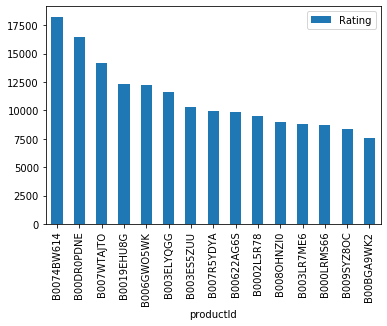

In [25]:
popular_products = pd.DataFrame(e_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(15).plot(kind = "bar")

###### By the above graph we can see the top 15 products recommended

## 3-- SPLITTING THE DATA 70/30 RATIO

In [26]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
ee_df = Dataset.load_from_df(e_df,reader)
trainset, testset = train_test_split(ee_df, test_size=0.3,random_state=10)

## 5 & 7-- COLABARATIVE FILTERING MODEL 
## BY USING K=5

In [27]:
# Fitting the data with k = 5
e_algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
#Training the dataset
e_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [28]:
#Test set
test_pred = e_algo.test(testset)

In [29]:
#Test predictions
test_pred

[Prediction(uid='A28NMZ7RDWH53M', iid='B001NS0OZ4', r_ui=5.0, est=4.535911602209945, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A2UTTR7KEU2AT8', iid='B007R5YDYA', r_ui=5.0, est=4.075046285042973, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3NL1XDSDDPBOV', iid='B0073HSH8U', r_ui=5.0, est=4.075046285042973, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A3W2C56SIG44D1', iid='B00565T3ZW', r_ui=5.0, est=4.075046285042973, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A30DQTMORVMZ5V', iid='B000A3XRSO', r_ui=4.0, est=4.075046285042973, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1SW7HUUO5LB9Q', iid='B002PU9PY0', r_ui=5.0, est=4.075046285042973, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AUBX5KIXRU9DC', iid='B002HWJT1A', r_ui=5.0

##### Top five recommendations for each user is given above

## 6-- RMSE VALUE

In [30]:
print("Item-Item collobarative model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-Item collobarative model : Test Set
RMSE: 1.3313


1.3313388227236338

###### Here RMSE value is close to one which not bad

## MODEL BASED COLLABARATIVE FILTERING TO GIVE TOP 5 PRODUCT
## RECOMMENDATIONS

In [31]:
# pivot table for first 50000 users
et_df=e_df.head(50000)
ratings_matrix = et_df.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00005A9AV,B00005AB9R,B00005ABC5,B00005AC8J,B00005AR4L,B00005ARK3,B00005ARK4,B00005AT7Y,B00005ATMB,B00005ATMI
userId,,,,,,,,,,,,,,,,,,,,,
A014623426J5CM7M12MBW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03279253KKB83JP34CU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
#Shape of ratings_matrix
ratings_matrix.shape

(47688, 212)

In [33]:
# Transpose of ratings_matrix
X = ratings_matrix.T
X.head()

userId,A014623426J5CM7M12MBW,A01852072Z7B68UHLI5UG,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A03279253KKB83JP34CU,A0478499AHWR7GZCCWR1,A05039072BTS8XOPJKBXB,A0571176384K8RBNKGF8O,A0586418108XHQA8T1IQO,A0590501PZ7HOWJKBGQ4,...,AZZ13K3ZG2XZC,AZZ77XYX8O2WE,AZZA7IQWTXCH3,AZZGJ2KMWB7R,AZZLKKDJSSSGL,AZZMV5VT9W7Y8,AZZOFVMQC0BJG,AZZP8BC9WE0N8,AZZUBI2MEAHI9,AZZZEWADNFNUM
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#shape of X matrix
X.shape

(212, 47688)

In [35]:
#Using truncated SVD to find decomposed matrix
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(212, 10)

In [36]:
decomposed_matrix

array([[ 8.85820778e-02,  6.87293550e-03,  3.64937493e-01, ...,
        -1.35255583e-01, -4.47016135e-01, -4.94972607e-03],
       [ 9.96909874e-04,  3.94533105e-04,  2.24264207e-04, ...,
         1.31871177e-02, -1.71251887e-03,  2.27988688e-02],
       [ 5.69935126e-02,  1.00784179e-03,  1.44811004e-03, ...,
         9.39043837e-04,  1.53237215e-04, -1.25579334e-03],
       ...,
       [ 9.74859870e-02,  9.93036874e-05,  8.16461986e-04, ...,
         1.22439014e-01,  4.30961700e-01,  1.40015488e-01],
       [ 1.48070716e-02,  8.57229251e-01,  9.38436328e-01, ...,
        -2.69350715e+00, -1.81517038e-01, -3.15950560e-02],
       [ 2.52689595e-01,  1.55082975e-04,  2.66643436e-03, ...,
         2.19547863e-01, -1.01007458e-01, -1.23322602e-02]])

In [37]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(212, 212)

In [38]:
correlation_matrix

array([[ 1.        , -0.02762457, -0.16619415, ..., -0.21075245,
        -0.10510578, -0.16657382],
       [-0.02762457,  1.        , -0.15542264, ...,  0.1236683 ,
         0.00515265,  0.03245549],
       [-0.16619415, -0.15542264,  1.        , ..., -0.15755113,
        -0.15963724, -0.0271028 ],
       ...,
       [-0.21075245,  0.1236683 , -0.15755113, ...,  1.        ,
        -0.20926302, -0.28773441],
       [-0.10510578,  0.00515265, -0.15963724, ..., -0.20926302,
         1.        ,  0.91068774],
       [-0.16657382,  0.03245549, -0.0271028 , ..., -0.28773441,
         0.91068774,  1.        ]])

In [39]:
X.index[119]

'B00004UE2R'

In [40]:
# index of the product purchased by customer
i = "B00004UE2R"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

119

In [41]:
# Correlation matrix
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(212,)

In [42]:
Recommend = list(X.index[correlation_product_ID > 0.45])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:5]

['B00000J061', 'B00000J1TX', 'B00000J1V3', 'B00000J1V5', 'B00000J434']

#### In this model top 5 products is recomended to the user without recomending product he already bought

## 8-- SUMMARY OF MY INSIGHTS

HERE IN MY PROJECT USING ELECTRONIC DATASET OF AMAZON

1. POPULARITY BASED MODEL IS BUILT TO RECOMMEND THE NEW USERS TOP MOST RATED PRODUCT BY MAXIMUM NUMBER OF USERS. THIS AVOIDS THE COLD START PROBLEM.

2. COLLABARATIVE FILTERING MODEL HAS BEEN BUILT TO RECOMMEND THE ITEMS SIMILAR TO THE ITEM USER BOUGHT. THIS MODEL GIVES RMSE VALUE OF 1.3 WHICH IS NOT BAD.

3. MODEL BASED COLLABARATIVE MODEL HAS BEEN BUILT TO GIVE TO FIVE RECOMMENDATIONS TO A USER EXCLUDING THE ITEM HE ALREADY BOUGHT.

THANK YOU.